In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import statsmodels.formula.api as sm
import patsy
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV,learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.pipeline import Pipeline

In [3]:
import glob, os     
extension = 'csv' 
all_filenames = [i for i in glob.glob('*.{}'.format(extension))] 
print(all_filenames)

#combine all files in the list 

df_raw = pd.concat([pd.read_csv(f, encoding='unicode escape',skiprows=0) for f in all_filenames ]) 
df_raw.reset_index(inplace=True) 
df_raw = df_raw.drop(columns=['index','Unnamed: 0']) 

['DS_27Mar2020a.csv', 'DS_27Mar2020b.csv', 'ML_27Mar2020b.csv', 'ML_27Mar2020a.csv', 'AI_26Mar2020.csv']


In [4]:
df_raw.shape

(1091, 11)

# EDA and Features Engineering

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job_Id           1043 non-null   object
 1   Emp_Type         1043 non-null   object
 2   Job_Title        1043 non-null   object
 3   Company          1043 non-null   object
 4   Date_Posted      1043 non-null   object
 5   Salary_Range     1043 non-null   object
 6   Salary_Type      1043 non-null   object
 7   Year_Experience  1043 non-null   object
 8   Seniority        1043 non-null   object
 9   Category         1043 non-null   object
 10  Requirements     1043 non-null   object
dtypes: object(11)
memory usage: 93.9+ KB


In [6]:
job_clean = df_raw.drop_duplicates(subset='Job_Id', keep='first') #remove duplicate based on Job ID

#drop Salary_Type due to only one unique value 'Monthly'
job_clean = job_clean.drop(columns='Salary_Type')
job_clean.shape

(802, 10)

In [7]:
job_clean.head(3)

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Salary_Range,Year_Experience,Seniority,Category,Requirements
0,[b'MCF-2020-0045240'],"[b'Contract, Full Time']","[b'Scientist (Machine Intellection), I2R']",[b'A*STAR RESEARCH ENTITIES'],[b'Posted 27 Mar 2020'],"[b'<div class=""lh-solid""><span class=""dib"">$4,...",[],[b'Professional'],[b'Sciences / Laboratory / R&amp;D'],"['\nDeveloping, enhancing, automating, and man..."
1,[b'MCF-2020-0045289'],"[b'Contract, Full Time']","[b'Scientist (Machine Intellection), I2R']",[b'A*STAR RESEARCH ENTITIES'],[b'Posted 27 Mar 2020'],"[b'<div class=""lh-solid""><span class=""dib"">$4,...",[],[b'Professional'],[b'Sciences / Laboratory / R&amp;D'],['\nProtein nodes discovering in cancer\nBioma...
2,[b'MCF-2020-0045282'],"[b'Contract, Full Time']","[b'Scientist (Machine Intellection), I2R']",[b'A*STAR RESEARCH ENTITIES'],[b'Posted 27 Mar 2020'],"[b'<div class=""lh-solid""><span class=""dib"">$4,...",[],[b'Professional'],[b'Sciences / Laboratory / R&amp;D'],['\nProtein nodes discovering in cancer\nBioma...


In [8]:
#perform data cleaning on every row and columms
clean_list = "(\[|\]|b'|Requirements|'|amp;|xa0|\\\|xe2x80x93|\\n|div class=|div class=|span class=|dib|lh-solid|/span|f5-5 i fw4 gray|f5 fw4 ph1|<|>|/div|\")"
for col in job_clean.columns.difference(['Requirements']):
    job_clean[col]=job_clean[col].str.replace(clean_list, "")

#space remain for Requirements column    
job_clean['Requirements']=job_clean['Requirements'].str.replace(clean_list, " ")
job_clean.head(2)

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Salary_Range,Year_Experience,Seniority,Category,Requirements
0,MCF-2020-0045240,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,"$4,500to$9,000",,Professional,Sciences / Laboratory / R&D,"Developing, enhancing, automating, and mana..."
1,MCF-2020-0045289,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,"$4,500to$9,000",,Professional,Sciences / Laboratory / R&D,Protein nodes discovering in cancer Biomark...


In [9]:
clean_list = "(Ã¢Â€Â|Ã¢Â€Âœ|Ã¢Â€Â™|ïƒ¼ Â|ïƒ¨|ïƒ¼|Â Â Â Â Â|Â|â€“|â€™|â€œâ€|)"
job_clean['Requirements']=job_clean['Requirements'].str.replace(clean_list, "")
job_clean.head(2)

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Salary_Range,Year_Experience,Seniority,Category,Requirements
0,MCF-2020-0045240,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,"$4,500to$9,000",,Professional,Sciences / Laboratory / R&D,"Developing, enhancing, automating, and mana..."
1,MCF-2020-0045289,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,"$4,500to$9,000",,Professional,Sciences / Laboratory / R&D,Protein nodes discovering in cancer Biomark...


In [10]:
#remove job without title
job_no_title = job_clean['Job_Title'] == ''
job_clean = job_clean[~job_no_title]

#remove row with Job_Title NaN
job_clean[job_clean.isnull().any(axis=1)]
job_clean = job_clean.dropna()
job_clean.shape

(801, 10)

In [11]:
#remove row without salary
no_salary = job_clean['Salary_Range'].str.contains('Salary undisclosed')

df_salary = job_clean[~no_salary]
print('with salary', df_salary.shape)
df_no_salary = job_clean[no_salary]
print('without salary', df_no_salary.shape)

with salary (775, 10)
without salary (26, 10)


In [12]:
#extract salary columns due to contain multiple information
salary_range = df_salary["Salary_Range"].str.split("to", n = 2, expand = True) 

#Give columns name to the dataframe
salary_range = salary_range.rename({0:'Min_Salary',1:'Max_Salary'}, axis='columns')

#removed $ and , from salary 
for col in salary_range.columns:
    salary_range[col]=salary_range[col].str.replace('(\$|,)', '')

#convert from ojbect to float for statistical infomation
salary_range['Min_Salary'] = salary_range['Min_Salary'].astype('float64')
salary_range['Max_Salary'] = salary_range['Max_Salary'].astype('float64')

salary_range.head(2)

,Min_Salary,Max_Salary
0,4500.0,9000.0
1,4500.0,9000.0


In [13]:
#concat min_max salary dataframe with salary range dataframe
df_salary1 = pd.concat([df_salary, salary_range], axis=1)
df_salary1 = df_salary1.drop(columns='Salary_Range')
df_salary1.head(1)

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary
0,MCF-2020-0045240,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,,Professional,Sciences / Laboratory / R&D,"Developing, enhancing, automating, and mana...",4500.0,9000.0


In [14]:
#from the min and max value, extream outliers were observed
df_salary1[['Min_Salary','Max_Salary']].describe()

,Min_Salary,Max_Salary
count,775.000000,775.000000
mean,5822.113548,9736.495484
std,5396.435909,7601.907104
min,4.000000,7.000000
25%,4000.000000,6500.000000
50%,5000.000000,9000.000000
75%,7000.000000,12000.000000
max,110000.000000,152000.000000


In [15]:
#create a condition to check for high outliers
abovemean_min = round(10*np.mean(df_salary1['Min_Salary']),0)
abovemean_max = round(10*np.mean(df_salary1['Max_Salary']),0)
print(abovemean_max)
print(abovemean_min)

#found salary which is 10 times higher than mean are actually Annual salary
df_salary1[(df_salary1['Min_Salary'] > abovemean_min) | (df_salary1['Max_Salary'] > abovemean_max)]

97365.0
58221.0


,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary
125,MCF-2020-0063368,Full Time,"Analytics Team Lead, Large Customers, South APAC",CRITEO SINGAPORE PTE. LTD.,Posted 13 Mar 2020,5 years exp,Manager,Advertising / Media,Manage the operations of Analytics team (al...,91040.0,152000.0
819,MCF-2020-0067727,"Permanent, Full Time",Quantitative Trader,ALPHAGREP PTE. LTD.,Posted 20 Mar 2020,1 year exp,Middle Management,Others,"A proven ability to develop new, profitable...",110000.0,120000.0


In [16]:
#convert yearly salary into monthly salary

df_salary1['Min_Salary'] = np.where((df_salary1['Min_Salary'] > abovemean_min),
                                    round((df_salary1['Min_Salary']/12),0), df_salary1['Min_Salary'])

df_salary1['Max_Salary'] = np.where((df_salary1['Max_Salary'] > abovemean_min),
                                    round((df_salary1['Max_Salary']/12),0), df_salary1['Max_Salary'])

In [17]:
#check unrealistic min and max monthly salary range (which is more than 10 times)
df_salary1.loc[(df_salary1['Max_Salary']>10*df_salary1['Min_Salary'])]

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary


In [18]:
#to drop job with max salary less than 2500, assuming data entry/admin/operator job

df_salary1.loc[(df_salary1['Min_Salary']<=1800) | (df_salary1['Max_Salary']<=2000)]

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary
346,MCF-2020-0061417,Full Time,data scientist & Python Developer,PLATINUM ANALYTICS SINGAPORE PTE. LTD.,Posted 12 Mar 2020,1 year exp,Non-executive,Professional Services,,4.0,7.0
642,MCF-2020-0072990,Internship,Junior Analyst Intern,XYPHER PTE. LTD.,Posted 27 Mar 2020,2 years exp,Executive,Information Technology,,1000.0,1200.0
768,MCF-2020-0069231,Contract,UX Designer,KNOWLEDGE NAVIGATOR PTE. LTD.,Posted 23 Mar 2020,1 year exp,Non-executive,"Design, Information Technology, Others",Build reusable libraries of interface artef...,1800.0,2500.0
882,MCF-2020-0065517,Full Time,Operations Associate,TAURUS ONE PRIVATE LIMITED,Posted 17 Mar 2020,1 year exp,Fresh/entry level,Logistics / Supply Chain,,1700.0,2200.0
948,MCF-2020-0066351,"Contract, Part Time",Research Assistant (Law),NANYANG TECHNOLOGICAL UNIVERSITY,Posted 18 Mar 2020,1 year exp,Professional,Legal,Conduct the search for latest literature (i...,1500.0,2300.0
981,MCF-2020-0061567,Permanent,IT Specialist,LITE-ON SINGAPORE PTE. LTD.,Posted 12 Mar 2020,2 years exp,Non-executive,Information Technology,Responsible for technical support for end u...,1800.0,2700.0
1027,MCF-2020-0056225,Full Time,Order Executive,STAFFONDEMAND PTE. LTD.,Posted 06 Mar 2020,2 years exp,Non-executive,"General Management, Sales / Retail",Handling of service provisioning responsibi...,1800.0,2200.0


In [19]:
#to drop job with max salary less than 2500, assuming data entry/admin/operator job
low_sal = ((df_salary1['Min_Salary']<=1800) | (df_salary1['Max_Salary']<=2500))
df_salary2 = df_salary1[~low_sal]

print(df_salary2.shape)
df_salary2.describe()

(767, 11)


,Min_Salary,Max_Salary
count,767.000000,767.000000
mean,5627.441982,9492.625815
std,2356.662769,3925.563351
min,2000.000000,2800.000000
25%,4000.000000,6500.000000
50%,5000.000000,9000.000000
75%,7000.000000,12000.000000
max,24000.000000,35000.000000


In [20]:
#further remove job with same data from all columns
job_df = df_salary2.drop_duplicates(subset=df_salary2.columns, keep='first')
job_df.shape

(767, 11)

In [21]:
#further filter on job title with specific keywords
title_key = ['DATA', 'MACHINE','ANALYST','MACHINE LEARNING','ANALYTICS', "SCIENCE", '4.0','APPLICATION'
             'DEEP LEARNING','RESEARCH','NLP', 'ARTIFICIAL', "INTELLIGENT", 'AI', 'SCIENTIST','SYSTEM'
             'Industry', 'IOT', 'FINANCE', 'FINTECH', 'SOFTWARE', 'ENGINEER', 'ENGINEERING','PROFESSOR'
             'BUSINESS', 'DEVELOPER', 'INDUSTRIAL','AUTOMATION', 'CLOUD','SOLUTION','ARCHITECT',
             'MANAGER','VP','PRESIDENT', 'TECHNOLOGY', 'SPECIALIST', 'TECHNICAL','LEAD','TECHNOLOGIST']
key = '|'.join(title_key)
data_job = job_df['Job_Title'].str.upper().str.contains(key)
job_df1 = job_df[data_job]
job_df1.shape

(703, 11)

In [22]:
#remove job title with unwanted keywords
title_key = ['PHYSIOTHERAPIST','ACCOUNT','AUDIT','COUNSEL','EXECUTIVE','SALES','GENERAL','MARKET','ELECTRICAL',
             'BUSINESS','ADMIN','CUSTOMER','OFFICER','OPERATION', 'MECHANICAL','CHEMICAL','COORDINATOR','LECTURER',
             'TECHNICIAN']
key = '|'.join(title_key)
non_data_job = job_df['Job_Title'].str.upper().str.contains(key)
job_df1 = job_df[~non_data_job]
job_df1.shape

(637, 11)

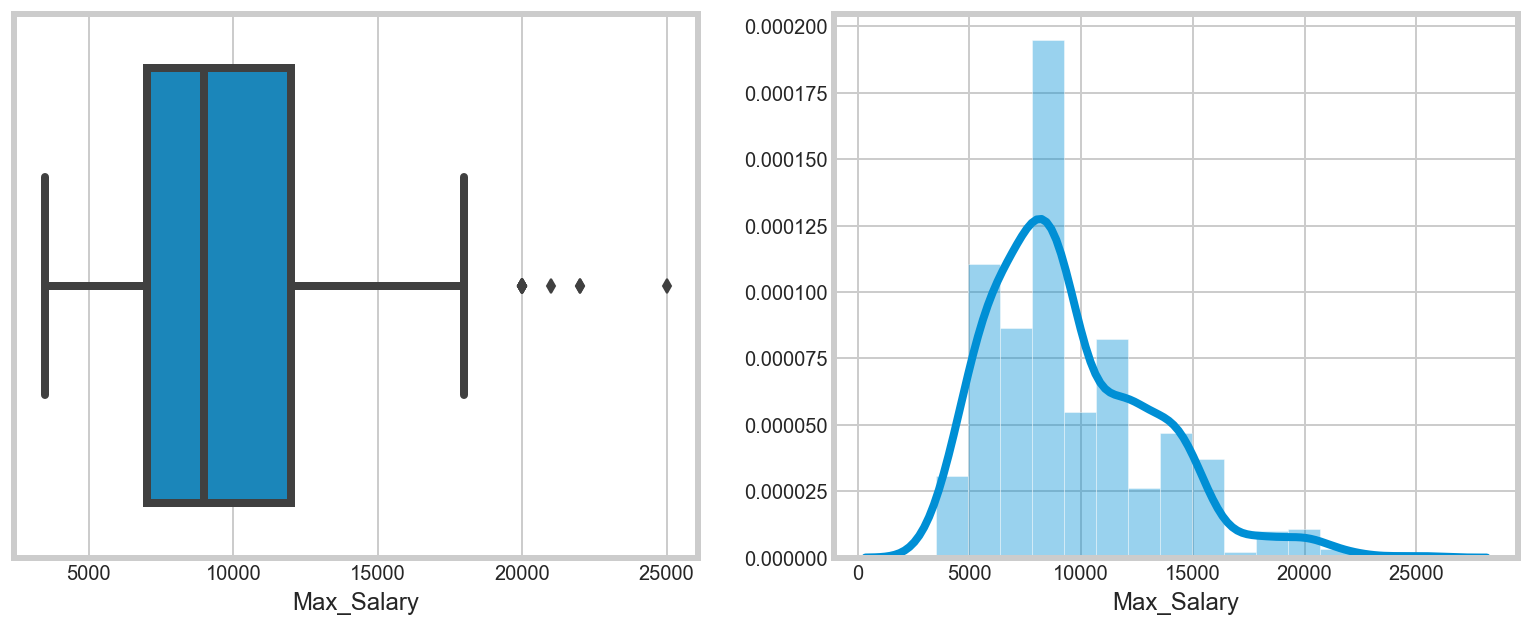

In [23]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(job_df1['Max_Salary'], ax=ax[0])
sns.distplot(job_df1['Max_Salary'],bins=15, ax=ax[1])

After few extream outliers were removed, median for sal_max is around $7500 but there are still few job with very high monthly salary

In [24]:
job_df1[job_df1['Max_Salary']>20000].groupby(['Company', 'Seniority']).count()

,,Job_Id,Emp_Type,Job_Title,Date_Posted,Year_Experience,Category,Requirements,Min_Salary,Max_Salary
Company,Seniority,,,,,,,,,
AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED,Professional,1,1,1,1,1,1,1,1,1
GO-JEK SINGAPORE PTE. LTD.,Senior Management,1,1,1,1,1,1,1,1,1
STANDARD CHARTERED BANK (SINGAPORE) LIMITED,Middle Management,1,1,1,1,1,1,1,1,1
ZEBRA TECHNOLOGIES ASIA PACIFIC PTE. LTD.,Senior Management,1,1,1,1,1,1,1,1,1


In [25]:
#create new feature for average salary
job_df1['Avg_Salary'] = (job_df1['Min_Salary'] + job_df1['Max_Salary']) / 2
print(job_df1.shape)
job_df1['Avg_Salary'].describe()

(637, 12)


count      637.000000
mean      7542.431711
std       2780.238389
min       3000.000000
25%       5500.000000
50%       6750.000000
75%       9000.000000
max      20000.000000
Name: Avg_Salary, dtype: float64

In [26]:
salary_outlier = ((job_df1['Avg_Salary']>20000) | (job_df1['Avg_Salary']<3000))
job_df1 = job_df1[~salary_outlier]
job_df1.shape

(637, 12)

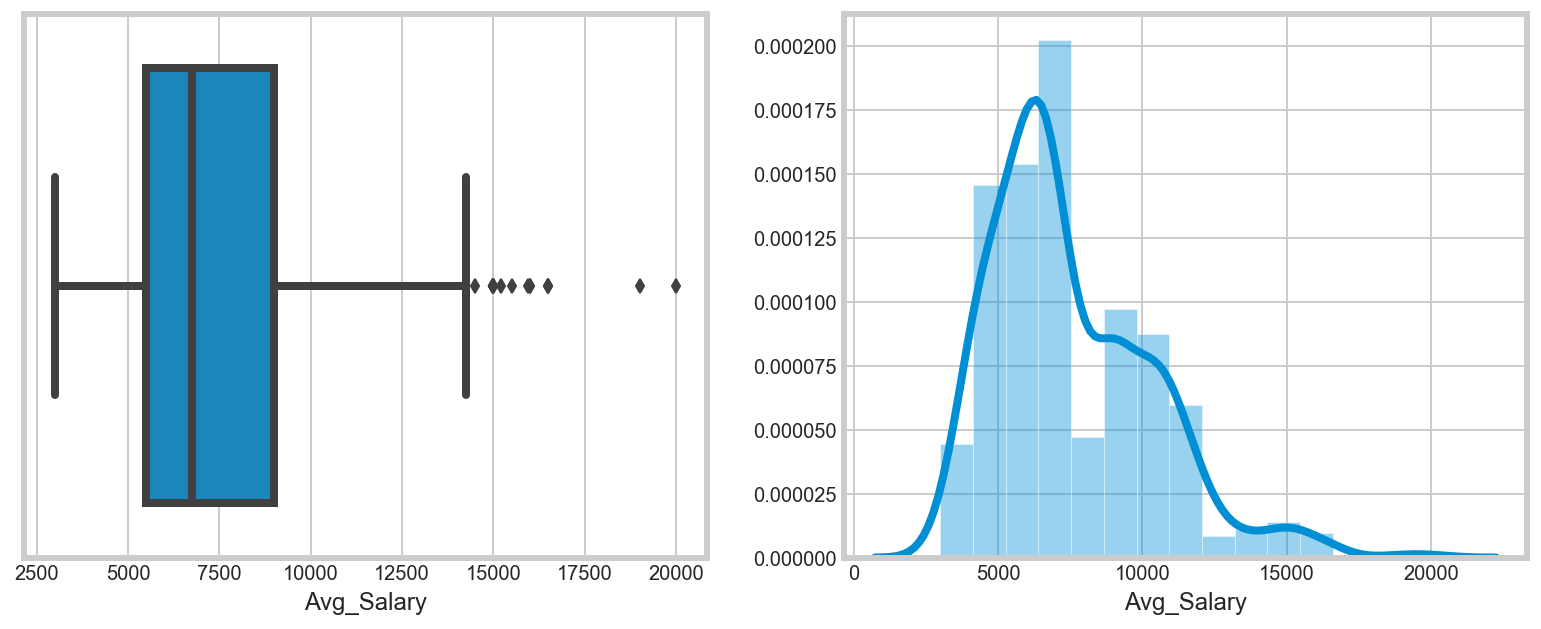

In [27]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(job_df1['Avg_Salary'], ax=ax[0])
sns.distplot(job_df1['Avg_Salary'],bins=15, ax=ax[1])

Average monthly salary column was created for labeling purpose for next step. The mean value around 7500 for the average salary and median at 6750, which in Singapore is consider as high pay.
Next label was created for high and low salary according to median salary.

In [28]:
#bin salary into 4 groups:
#3000 to 5500 - Low
#5500 to 8000 - Med
#8000 and above - High

bins = [3000, 5500, 8000, np.inf]
names = ['Low', 'Med', 'High']

job_df1['Salary_range'] = pd.cut(job_df1['Avg_Salary'], bins, labels=names)
job_df1 = job_df1.reset_index(drop=True)
job_df1.head()

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
0,MCF-2020-0045240,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,,Professional,Sciences / Laboratory / R&D,"Developing, enhancing, automating, and mana...",4500.0,9000.0,6750.0,Med
1,MCF-2020-0045289,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,,Professional,Sciences / Laboratory / R&D,Protein nodes discovering in cancer Biomark...,4500.0,9000.0,6750.0,Med
2,MCF-2020-0045282,"Contract, Full Time","Scientist (Machine Intellection), I2R",A*STAR RESEARCH ENTITIES,Posted 27 Mar 2020,,Professional,Sciences / Laboratory / R&D,Protein nodes discovering in cancer Biomark...,4500.0,9000.0,6750.0,Med
3,MCF-2020-0072490,Permanent,"Data Science Experimentation Specialist, Apple...",APPLE SOUTH ASIA PTE. LTD.,Posted 26 Mar 2020,10 years exp,Executive,Engineering,,8000.0,16000.0,12000.0,High
4,MCF-2020-0072489,Permanent,"Data Science Experimentation Specialist, Apple...",APPLE SOUTH ASIA PTE. LTD.,Posted 26 Mar 2020,5 years exp,Executive,Engineering,,6000.0,11000.0,8500.0,High


In [29]:
job_df1['Salary_range'].value_counts()

Med     250
High    227
Low     159
Name: Salary_range, dtype: int64

In [30]:
#check seniority with multiple rank
job_df1[job_df1['Seniority'].str.count(',')>=1].head()

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
92,MCF-2020-0063470,Full Time,User Research Lead,STAFFONDEMAND PTE. LTD.,Posted 13 Mar 2020,7 years exp,"Manager, Executive",Marketing / Public Relations,Both a Lead and a Practitioner - Lead a tea...,6000.0,12000.0,9000.0,High
175,MCF-2020-0049715,"Contract, Freelance",Associate Trainer â ICT,STAFFONDEMAND PTE. LTD.,Posted 28 Feb 2020,5 years exp,"Manager, Executive",Education and Training,Conduct ICT vendor-based training as per SS...,3000.0,5000.0,4000.0,Low
391,MCF-2020-0049706,"Contract, Freelance",Associate Trainer â Microsoft Technical Courses,STAFFONDEMAND PTE. LTD.,Posted 28 Feb 2020,5 years exp,"Manager, Executive",Education and Training,Deliver classroom training and conduct comp...,3000.0,5000.0,4000.0,Low
624,MCF-2020-0052814,Full Time,Group Product Manager â Mobile Application a...,STAFFONDEMAND PTE. LTD.,Posted 03 Mar 2020,10 years exp,"Middle Management, Manager","Marketing / Public Relations, Sales / Retail",Taking full responsibility for the Strategy...,9000.0,14000.0,11500.0,High


In [31]:
job_df1[(job_df1['Seniority']=='')]

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
190,JOB-2018-0215413,Full Time,Data Analytics Lead,GOVERNMENT TECHNOLOGY AGENCY,Posted 06 Dec 2019,,,"Information Technology, Public / Civil Service",Chart and drive the data analytics strategy...,5000.0,14000.0,9500.0,High
426,JOB-2019-0235741,Full Time,"Software Engineer, Artificial Intelligence Pla...",GOVERNMENT TECHNOLOGY AGENCY,Posted 06 Dec 2019,,,"Information Technology, Public / Civil Service",Build prototypes to demonstrate technology...,6000.0,11000.0,8500.0,High


In [32]:
job_df1['Seniority'][92,190] = 'Manager'
job_df1['Seniority'][175,391,] = 'Executive'
job_df1['Seniority'][426] = 'Professional'
job_df1['Seniority'][624] = 'Middle Management'

In [33]:
job_df1['Seniority'].value_counts()

Professional         280
Executive            130
Senior Executive      68
Manager               48
Middle Management     30
Fresh/entry level     25
Non-executive         22
Junior Executive      21
Senior Management     13
Name: Seniority, dtype: int64

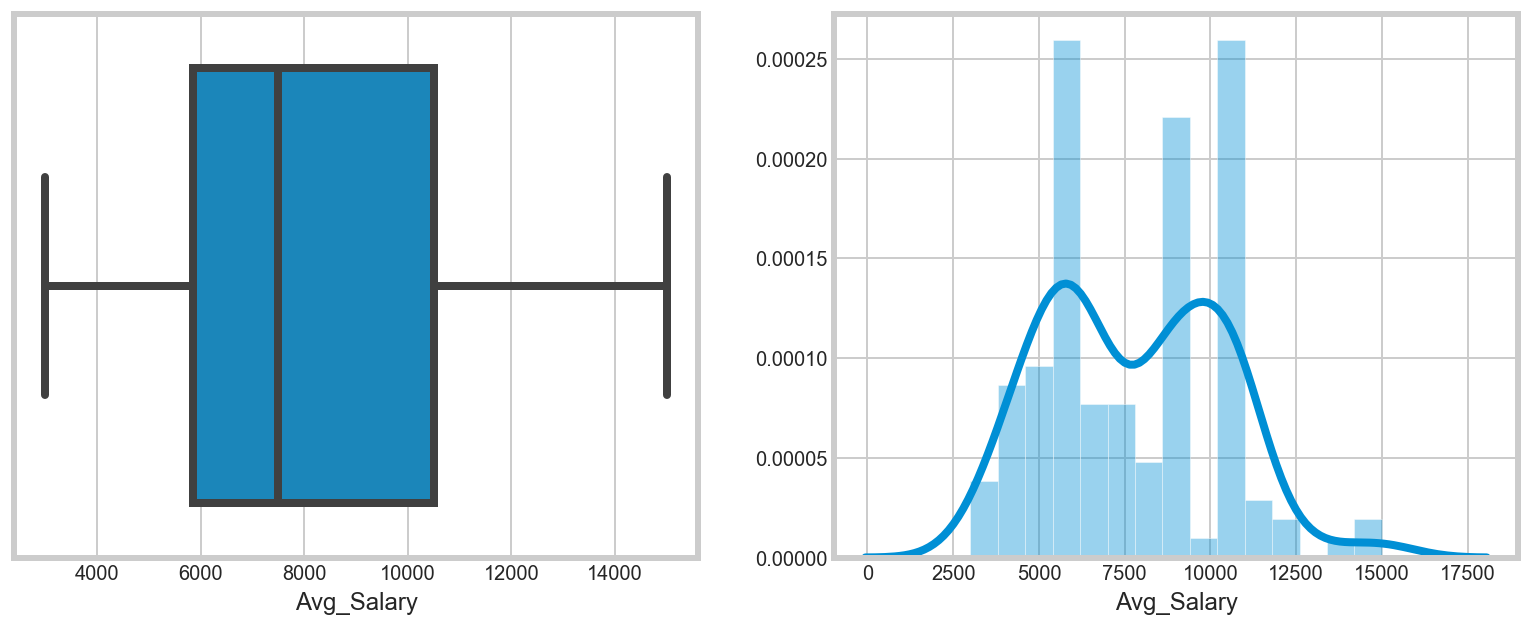

In [34]:
exec_only = job_df1['Seniority']=='Executive'
job_exec = job_df1[exec_only]

fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(job_exec['Avg_Salary'], ax=ax[0])
sns.distplot(job_exec['Avg_Salary'],bins=15, ax=ax[1])

In [35]:
job_df1[(job_df1['Seniority']=='Executive') & (job_df1['Avg_Salary']>8000)]

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
3,MCF-2020-0072490,Permanent,"Data Science Experimentation Specialist, Apple...",APPLE SOUTH ASIA PTE. LTD.,Posted 26 Mar 2020,10 years exp,Executive,Engineering,,8000.0,16000.0,12000.0,High
4,MCF-2020-0072489,Permanent,"Data Science Experimentation Specialist, Apple...",APPLE SOUTH ASIA PTE. LTD.,Posted 26 Mar 2020,5 years exp,Executive,Engineering,,6000.0,11000.0,8500.0,High
35,MCF-2020-0070145,Permanent,Data Scientist - (Full Stack Developer),LMA RECRUITMENT SINGAPORE PTE. LTD.,Posted 24 Mar 2020,5 years exp,Executive,Information Technology,,7000.0,10000.0,8500.0,High
36,MCF-2020-0070323,Full Time,Finance Associate,NETFLIX PTE. LTD.,Posted 24 Mar 2020,5 years exp,Executive,Banking and Finance,"The Associate will report to the Manager, C...",12000.0,15000.0,13500.0,High
107,MCF-2020-0060440,"Permanent, Full Time",Data Scientist (Optimization),CARTRACK TECHNOLOGIES SOUTH EAST ASIA PTE. LTD.,Posted 11 Mar 2020,4 years exp,Executive,Information Technology,Conceptualize and develop real-time models ...,8500.0,13000.0,10750.0,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,MCF-2020-0066258,Full Time,Senior Data Scientist,AGODA COMPANY PTE. LTD.,Posted 18 Mar 2020,5 years exp,Executive,Information Technology,Crack our business problems and come up wit...,9000.0,15000.0,12000.0,High
564,MCF-2020-0066678,"Contract, Permanent, Full Time","Java Software Engineer, Payments Technology - ...","JPMORGAN CHASE BANK, N.A.",Posted 18 Mar 2020,6 years exp,Executive,Banking and Finance,BS/BA degree or equivalent experience Advan...,7000.0,14000.0,10500.0,High
567,MCF-2020-0066675,"Contract, Permanent, Full Time","Java Software Engineer, Payments Technology - ...","JPMORGAN CHASE BANK, N.A.",Posted 18 Mar 2020,6 years exp,Executive,Banking and Finance,BS/BA degree or equivalent experience Advan...,6000.0,12000.0,9000.0,High
591,MCF-2020-0070472,"Contract, Full Time","Senior Bioinformatician (CBAU), IMCB",A*STAR RESEARCH ENTITIES,Posted 24 Mar 2020,,Executive,Sciences / Laboratory / R&D,"Masters degree in bioinformatics, biostatis...",5900.0,11800.0,8850.0,High


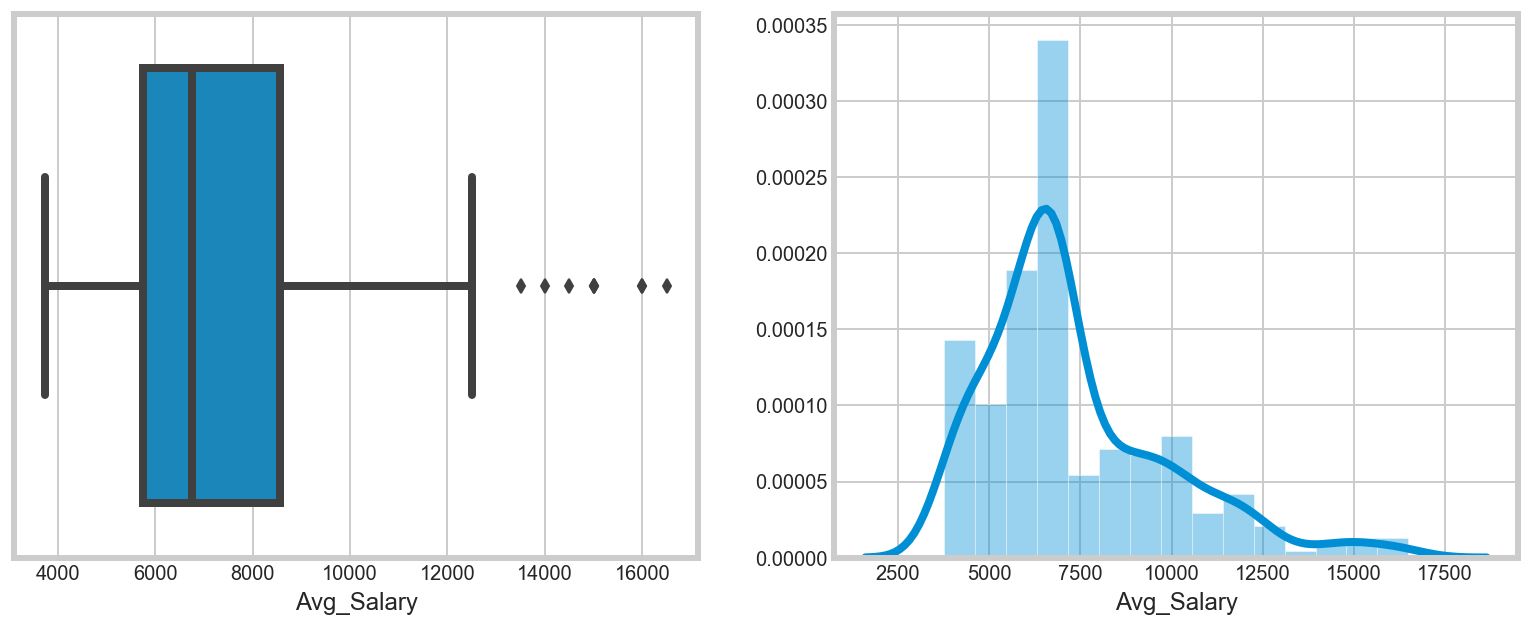

In [36]:
pro_only = job_df1['Seniority']=='Professional'
job_pro = job_df1[pro_only]

fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(job_pro['Avg_Salary'], ax=ax[0])
sns.distplot(job_pro['Avg_Salary'],bins=15, ax=ax[1])

In [37]:
job_df1['Seniority'].value_counts()

Professional         280
Executive            130
Senior Executive      68
Manager               48
Middle Management     30
Fresh/entry level     25
Non-executive         22
Junior Executive      21
Senior Management     13
Name: Seniority, dtype: int64

In [38]:
#Re-group Seniority from 9 groups to 4 groups

job_df1['Seniority'] = np.where((job_df1['Seniority'] == 'Fresh/entry level') | (job_df1['Seniority'] == 'Non-executive') | (job_df1['Seniority'] == 'Junior Executive'),
                                 'Jr Executive', job_df1['Seniority'])

job_df1['Seniority'] = np.where((job_df1['Seniority'] == 'Executive') | (job_df1['Seniority'] == 'Senior Executive'),
                                 'Sr Executive', job_df1['Seniority'])

job_df1['Seniority'] = np.where((job_df1['Seniority'] == 'Manager') | (job_df1['Seniority'] == 'Middle Management') | (job_df1['Seniority'] == 'Senior Management'),
                                 'Management', job_df1['Seniority'])


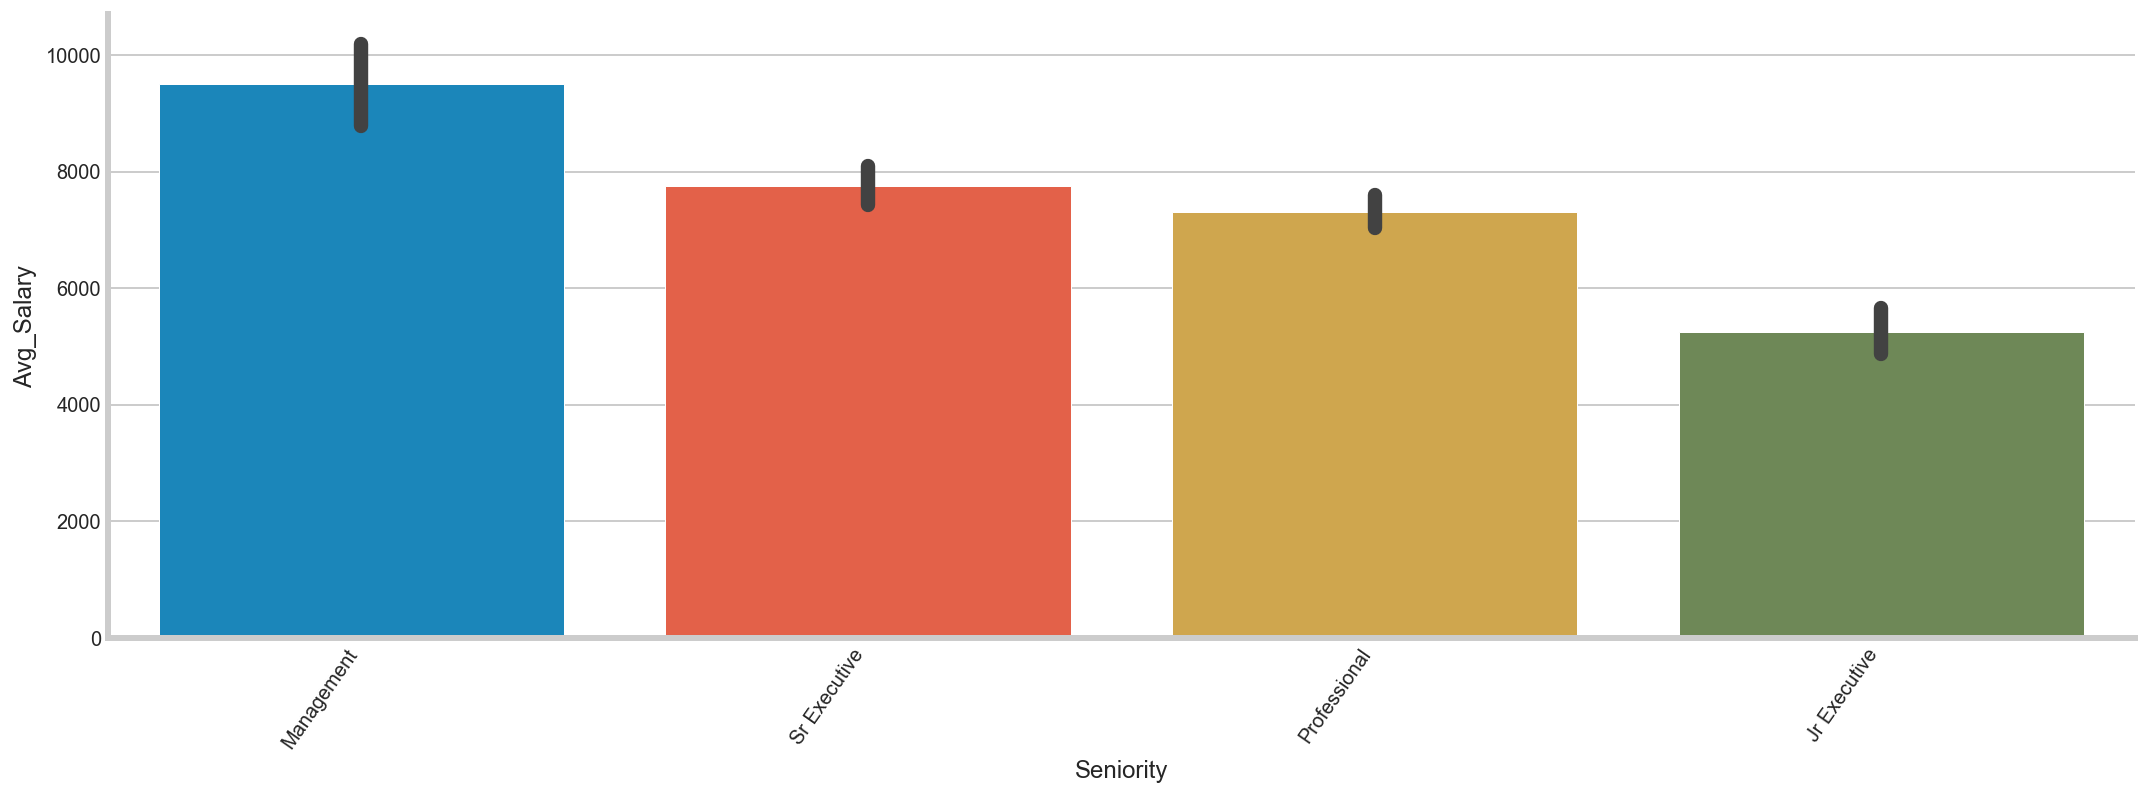

In [39]:
senior_order = ('Management','Sr Executive','Professional', 'Jr Executive')

sns.catplot(x='Seniority', y='Avg_Salary',data=job_df1, kind='bar', aspect=3, 
               order=senior_order).set_xticklabels(rotation=55, horizontalalignment='right')
plt.show();

In [40]:
#perform data cleaning on every row and columms
clean_list = "(Â|Ã¢Â€Â™️)"
job_df1['Requirements']=job_df1["Requirements"].str.replace(clean_list, "")
job_df1.tail(2)

,Job_Id,Emp_Type,Job_Title,Company,Date_Posted,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
635,MCF-2020-0047963,Contract,Project Manager,HUDSON RPO (SINGAPORE) PTE. LTD.,Posted 26 Feb 2020,5 years exp,Management,Others,Manage Medium to Large scale projects Manag...,7000.0,13000.0,10000.0,High
636,MCF-2020-0047534,Full Time,Product Manager,DATHENA SCIENCE PTE. LTD.,Posted 26 Feb 2020,,Jr Executive,"Design, Engineering, Information Technology, O...",As a product manager for Dathena you will b...,4000.0,6500.0,5250.0,Low


In [41]:
#extract only number from string
job_df1['Year_Experience'] = job_df1['Year_Experience'].str.extract('(\d+)')
job_df1['Year_Experience'].unique()

array([nan, '10', '5', '3', '2', '4', '1', '7', '8', '6', '15', '9', '12',
       '20'], dtype=object)

In [42]:
job_df1[~job_df1['Emp_Type'].str.contains('Part Time')]
#remove job type with specific keywords
type_key = ['PART TIME','TEMPORARY','INTERNSHIP','FLEXI','FREELANCE']
key = '|'.join(type_key)
non_type = job_df1['Emp_Type'].str.upper().str.contains(key)
job_df = job_df1[~non_type]
job_df.shape

(627, 13)

In [43]:
clean_list = "(Full Time|Permanent, Full Time)"
job_df['Emp_Type']=job_df['Emp_Type'].str.replace(clean_list, "Permanent")

clean_list = "(Contract, Full Time)"
job_df['Emp_Type']=job_df['Emp_Type'].str.replace(clean_list, "Contract")

clean_list = "(Contract, Permanent, Full Time)"
job_df['Emp_Type']=job_df['Emp_Type'].str.replace(clean_list, "Cont_Perm")

In [44]:
job_df['Emp_Type'].value_counts()

Permanent              379
Contract, Permanent    211
Contract                37
Name: Emp_Type, dtype: int64

In [45]:
job_df = job_df.drop(columns=['Date_Posted'])

In [46]:
clean_list = "(/|and)"
job_df['Category']=job_df['Category'].str.replace(clean_list, ",")
job_df.tail()

,Job_Id,Emp_Type,Job_Title,Company,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
632,MCF-2020-0049341,Permanent,User Experience Designer,PCCW SOLUTIONS SINGAPORE PTE. LTD.,8,Professional,Telecommunications,Acquire profound understanding of the Telco...,5000.0,9000.0,7000.0,Med
633,MCF-2020-0049160,"Contract, Permanent","Research Engineer, Social and Cognitive Comput...",A*STAR RESEARCH ENTITIES,NaN,Jr Executive,"Engineering, Information Technology, Sciences ...",Artificial Intelligence Systems Physics an...,3000.0,6000.0,4500.0,Low
634,MCF-2020-0047979,Permanent,Project Manager,HUDSON RPO (SINGAPORE) PTE. LTD.,5,Management,Others,Manage Medium to Large scale projects Manag...,7000.0,13000.0,10000.0,High
635,MCF-2020-0047963,Contract,Project Manager,HUDSON RPO (SINGAPORE) PTE. LTD.,5,Management,Others,Manage Medium to Large scale projects Manag...,7000.0,13000.0,10000.0,High
636,MCF-2020-0047534,Permanent,Product Manager,DATHENA SCIENCE PTE. LTD.,NaN,Jr Executive,"Design, Engineering, Information Technology, O...",As a product manager for Dathena you will b...,4000.0,6500.0,5250.0,Low


In [47]:
#count number of different categories inside category column
job_df['Cat_num'] = job_df['Category'].str.count(',')

In [48]:
multiple_cat = job_df['Cat_num']>5
df = job_df[~multiple_cat]

In [49]:
#remove job cat with specific keywords
rare_cat_key = ['HUMAN','SOCIAL','THERAPY','TAXATION','CUSTOMER','INTERIOR', 'ADMIN','BUILDING',
                'SECRETARIAL','INVESTIGATION', 'AUDITING', 'ENVIRONMENT','SALES', 'MARKETING',
                'ADVERTISING','CONSTRUCTION', 'DESIGN','LEGAL','HOSPITALITY','PROFESSIONAL']
key = '|'.join(rare_cat_key)
rare_cat = df['Category'].str.upper().str.contains(key)
df1 = df[~rare_cat]
df1.shape

(598, 13)

In [50]:
#remove job title with specific keywords
rare_title_key = ['DESIGNER','PROJECT','TECHNICIAN','EQUIP','DEVELOPMENT','COMPLIANCE',
                  'TRADER','PORTFOLIO','PROFESSIONAL','CREDIT','INVESTOR',
                  'DESIGN', 'LEGAL','SOFTWARE']
key = '|'.join(rare_title_key)
rare_title = df1['Job_Title'].str.upper().str.contains(key)
df2 = df1[~rare_title]
df2 = df2.drop(columns='Cat_num')
df2.shape

(467, 12)

In [51]:
df2 = df2.reset_index()
df2 = df2.drop(columns='index')
df2.tail()

,Job_Id,Emp_Type,Job_Title,Company,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
462,MCF-2020-0050095,Permanent,DevOps Engineer,UCARE.IO PTE. LTD.,2,Sr Executive,Information Technology,Develop and lead the code deployment proces...,4000.0,8000.0,6000.0,Med
463,MCF-2020-0049508,Permanent,Technology Manager,SIMPLIFYNEXT PTE. LTD.,8,Management,"Consulting, Information Technology",Manage project teams within a technical pro...,6000.0,12000.0,9000.0,High
464,MCF-2020-0048653,Permanent,Senior Research Scientist in Artificial Intell...,NANYANG TECHNOLOGICAL UNIVERSITY,3,Professional,"Education , Training","Cognitive, Emotional and Social Learning (C...",8050.0,16050.0,12050.0,High
465,MCF-2020-0048630,Permanent,Research Scientist in Artificial Intelligence ...,NANYANG TECHNOLOGICAL UNIVERSITY,3,Professional,"Education , Training","Cognitive, Emotional and Social Learning (C...",4600.0,9200.0,6900.0,Med
466,MCF-2020-0049160,"Contract, Permanent","Research Engineer, Social and Cognitive Comput...",A*STAR RESEARCH ENTITIES,NaN,Jr Executive,"Engineering, Information Technology, Sciences ...",Artificial Intelligence Systems Physics an...,3000.0,6000.0,4500.0,Low


In [52]:
req_empty = []

for i in range (len(df2)):
    
    if((len(df2['Requirements'][i]))<5):
        req_empty.append(i)

In [53]:
#clean & remove row without requirements
df2['Requirements']=df2['Requirements'].str.replace('(\n)', '')
df2 = df2.drop(req_empty)
df3 = df2.copy()
df3 = df3.reset_index()
df3 = df3.drop(columns='index')
print(df3.shape)
df3.tail(2)

(361, 12)


,Job_Id,Emp_Type,Job_Title,Company,Year_Experience,Seniority,Category,Requirements,Min_Salary,Max_Salary,Avg_Salary,Salary_range
359,MCF-2020-0048630,Permanent,Research Scientist in Artificial Intelligence ...,NANYANG TECHNOLOGICAL UNIVERSITY,3,Professional,"Education , Training","Cognitive, Emotional and Social Learning (C...",4600.0,9200.0,6900.0,Med
360,MCF-2020-0049160,"Contract, Permanent","Research Engineer, Social and Cognitive Comput...",A*STAR RESEARCH ENTITIES,NaN,Jr Executive,"Engineering, Information Technology, Sciences ...",Artificial Intelligence Systems Physics an...,3000.0,6000.0,4500.0,Low


In [ ]:
stacked = pd.DataFrame(df3['Category'].str.split(',').tolist()).stack()
cat_count = pd.DataFrame(stacked.value_counts(), columns=['Count']).reset_index()

In [ ]:
cat_count1 = []

for i in range (len(cat_count)):
    cat_count1.append(cat_count['index'][i].lstrip())
    
cat_clean = list(dict.fromkeys(cat_count1))
cat_clean

In [ ]:
#remove comma from cell with string
clean_list = "(,)"
for col in df3.columns.difference(['Year_Experience','Min_Salary','Max_Salary','Avg_Salary']):
    df3[col]=df3[col].str.replace(clean_list, "")
df3.tail(2)

In [ ]:
#remove extra whitespace between string
df4 = df3.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df4['Year_Experience'] = df4['Year_Experience'].fillna(0)

In [ ]:
df4.head()

df4.to_csv('JOB_DATA_v6.csv', index=False)

In [ ]:
#Dummified Seniority columns to use as predictor features
seniority_cat=df4['Seniority'].str.get_dummies()
salary_cat=df4['Salary_range'].str.get_dummies()

In [ ]:
df = pd.concat([df4, seniority_cat, salary_cat], axis=1)
df.shape

# QUESTION 1: Factors that impact salary

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

In [ ]:
#stop words were added to filter some generic recurring business terms.
stop = stopwords.words('english')
stop += ['regret','shortlisted', 'candidates','notified','etc', 'take', 'hands','added','able','writting',
         'year','years','least', 'related','using', 'and', 'ability','work','skills','advantage','written'
        'develop','good','team','design','knowledge','experience','following','areas', 'ability','and','in','to']

In [ ]:
def freq_words(word_count, features):

    num_word = np.asarray(word_count.sum(axis=0)).reshape(-1)
    most_count = num_word.argsort()[::-1]
    key_word = pd.Series(num_word[most_count], 
                           index=features[most_count])

    return key_word

In [ ]:
#most common words for requirements
cvt      =  CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=50000, min_df=1, max_df=0.9,
                       stop_words=stop, ngram_range=(1,2))
vect_word    =  cvt.fit_transform(df['Requirements'])
features  =  np.array(cvt.get_feature_names()) 

key_word = freq_words(vect_word, features)
key_word[key_word<5]

In [ ]:
new_stop = key_word[key_word<5].index
stop.extend(new_stop)

In [ ]:
#word count function

def word_count(df_col):

    str_counts = 0
    sum_str = 0

    for i in range (len(df_col)):    
        str_counts = len(df_col[i].split())
        sum_str = sum_str + str_counts

    print(sum_str)

In [ ]:
word_count(df4['Requirements'])

In [ ]:
df5 = df4.copy()

In [ ]:
#stop word filter

pat = r'\b(?:{})\b'.format('|'.join(stop))
df5['Requirements'] = df5['Requirements'].str.replace(pat, '')
df5['Requirements'] = df5['Requirements'].map(lambda x: x.strip())
df5['Requirements'] = df5['Requirements'].replace({' +':' '},regex=True)

In [ ]:
word_count(df5['Requirements'])

In [ ]:
from collections import Counter
import re

rows_list = []
word_df = pd.DataFrame()

for i in range (len(df5['Requirements'])): 
    
    words = re.findall('\w+', df5['Requirements'][i])
#    print(words[:10])
    top_10 = Counter(words).most_common(10)
    counts = Counter(words).values()
#    rows_list.append(top_10)
#   print(rows_list)
    df = pd.DataFrame(top_10, columns = ['Word', 'Counts'])
    word_df = pd.concat([word_df, df])
    
word_df = word_df.reset_index()
word_df.shape
#dict1 = pd.DataFrame(rows_list)
#dict1

In [ ]:
word_df.head()

In [ ]:
word_df = word_df.drop(columns=['index'])

In [ ]:
df_word = word_df.groupby('Word')['Counts'].sum()
df_word = df_word.sort_values(ascending=False)
print(df_word.shape)
df_word.head(20)

df5.to_csv('JOB_DATA_v8.csv', index=False, encoding='utf-8')

Checking keyword with countvetorizer with number of features set to 1500, minimun appearance of 5 times from different row and maximum apperance of not more than 70% in the overall dataset. Common word for data related job such as data, skills, knowledge, ability still can be observed after the setting the parameters.

In [ ]:
#most common ngrams for requirements
cvt = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.6,
                       stop_words=stop, ngram_range=(2,2))
vect_word = cvt.fit_transform(df5['Requirements'])
features  =  np.array(cvt.get_feature_names())

key_word = freq_words(vect_word, features)
key_word[:20]

Limit ngram to 2, data science related keywords can be observed such as machine learning, big data and computer science

In [ ]:
tfid = TfidfVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7,
                       stop_words=stop, ngram_range=(2,2))
tfid_word = tfid.fit_transform(df5['Requirements'])
features  =  np.array(tfid.get_feature_names())

key_word = freq_words(tfid_word, features)
key_word[:10]

Tried with TFID vectorizer on ngam=2 but result shows no siginifiant different from Count vectorizer, hence for the modeling will just stick with Count Vectorizer

In [ ]:
#CountVectorizer job requirements columns
cvec = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7, 
                       stop_words=stop,ngram_range=(2,3))
cvec.fit(df['Requirements'])

In [ ]:
print(df.shape)
#df = df.drop(columns='Job_Id')
df.tail(2)

In [ ]:
df[df['Salary_range'].isnull()]

In [ ]:
sal_no_range = df['Salary_range'].isnull()
df1 = df[~sal_no_range].reset_index()
df1 = df1.drop(columns='index')

In [ ]:
df1.head()

In [ ]:
#creating predictor and target dataset
model_data = df1.drop(columns=['Job_Title','Company','Seniority','Category','Min_Salary',
                               'Max_Salary','Emp_Type', 'Avg_Salary'])

nlp = pd.DataFrame(cvec.transform(model_data['Requirements']).todense(),columns=cvec.get_feature_names())

senior_nlp = pd.concat([model_data, nlp], axis=1)

In [ ]:
print(model_data.shape)
print(nlp.shape)
print(senior_nlp.shape)

In [ ]:
nlp.head()

In [ ]:
X = senior_nlp.drop(columns=['Salary_range','Requirements'])
X_nlp = nlp
y = senior_nlp['Salary_range'].values
X.shape

In [ ]:
#Data with dummified 'seniority' and countvectorized 'requirements'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('X_Train',X_train.shape)
print('y_Train',y_train.shape)
print('X_Test',X_test.shape)
print('y_Test',y_test.shape)

In [ ]:
#Data with countvectorized 'requirements' only
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(X_nlp, y, test_size=0.3, random_state=42)

In [ ]:
print('X_Train_nlp',X_train_nlp.shape)
print('y_Train_nlp',y_train_nlp.shape)
print('X_Test_nlp',X_test_nlp.shape)
print('y_Test_nlp',y_test_nlp.shape)

### Choosing the best model (Logistic, AdaBoost or RandomForest)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier(max_depth=4, random_state=42)
dtc = dtc.fit(X_train , y_train)

dtc1 = DecisionTreeClassifier(max_depth=4, random_state=42)
dtc_nlp = dtc1.fit(X_train_nlp , y_train_nlp)

In [ ]:
print(classification_report(y_test,dtc.predict(X_test),target_names=["Low", "Med", "High"]))

In [ ]:
pd.DataFrame(confusion_matrix(y_test,dtc.predict(X_test)),
             index=['Actual Low','Actual Med', 'Actual High'],
             columns=['Pred Low','Pred Med','Pred High'])

In [ ]:
print(classification_report(y_test_nlp,dtc_nlp.predict(X_test_nlp),target_names=["Low", "Med", "High"]))

In [ ]:
pd.DataFrame(confusion_matrix(y_test_nlp,dtc_nlp.predict(X_test_nlp)),
             index=['Actual Low','Actual Med', 'Actual High'],
             columns=['Pred Low','Pred Med','Pred High'])

#Logistic regression model (can't use on multiclass target)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('CV score on NLP+Seniority dummy data:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on NLP data:', np.mean(cross_val_score(lr, X_train_nlp, y_train_nlp, cv=5, scoring='roc_auc')))

#Adaboost model
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier(random_state=42)
Ada.fit(X_train, y_train)
print('CV score on NLP+Seniority dummy data:', np.mean(cross_val_score(Ada, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on NLP data:', np.mean(cross_val_score(Ada, X_train_nlp, y_train_nlp, cv=5, scoring='roc_auc')))

#RandomForest model
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
print('CV score on NLP+Seniority dummy data:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on NLP data:', np.mean(cross_val_score(rfc, X_train_nlp, y_train_nlp, cv=5, scoring='roc_auc')))

Data consists of dummified seniority plus CountVectorized requirements provide better cross val score across all models. Logistic regression model performed better in cross val score compare to ensemble models (AdaBoost and RandomForest).

### Logistic regression model with hyperparameter tune and classfication report

In [ ]:
#hyperparameter tune for logistic regression
lr_params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
gs_lr = GridSearchCV(lr, param_grid=lr_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_lr.fit(X_train,y_train)

lr_c2=gs_lr.best_estimator_
lr_c2.fit(X_train,y_train)

print('CV score on train data:', np.mean(cross_val_score(lr_c2, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on test data:', np.mean(cross_val_score(lr_c2, X_test, y_test, cv=5, scoring='roc_auc')))

In [ ]:
pd.DataFrame(confusion_matrix(y_test,lr_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

In [ ]:
print(classification_report(y_test,lr_c2.predict(X_test),target_names=["Low Salary", "High Salary"]))

Both class under train/test data are balance, so AUC score was chosen as valuation parameter. In overall the model is able to predict better than the baseline.
Recall for low salary indicates 23 out of 75 low salary jobs are predicted as high salary which is the major concern for bonus question. This will be handled in the next part.

In [ ]:
features = np.array(X_train.columns)
lr_coefs = pd.DataFrame({'coef':lr_c2.coef_[0], 'abs coef':abs(lr_c2.coef_[0])},index=features)
lr_coefs = lr_coefs.sort_values('coef',ascending=False)
lr_coefs.head(5)

In [ ]:
lr_coefs.tail(5)

Logisitic regression model is able to provide both positive and negative coefficient, which allow us to find out features that contribute to high salary and low salary as well.
From the features, apart from seniority level, education level such as phD holder vs diploma, work experience and skill such as hadoop have a direct impact on the salary.

### Random Forest model with hyperparameter tune and classfication report

In [ ]:
rfc_params={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'n_estimators': [50,100,150,200]}

gs_rfc=GridSearchCV(rfc, rfc_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_rfc.fit(X_train,y_train)

rfc2=gs_rfc.best_estimator_
rfc2.fit(X_train,y_train)

print('CV score on train data:', np.mean(cross_val_score(rfc2, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on test data:', np.mean(cross_val_score(rfc2, X_test, y_test, cv=5, scoring='roc_auc')))

In [ ]:
pd.DataFrame(confusion_matrix(y_test,rfc2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

In [ ]:
print(classification_report(y_test,rfc2.predict(X_test),target_names=["Low Salary", "High Salary"]))

From the test data cross val score, random forest is slightly lower compare to logistic regression but higher precision and recall score

In [ ]:
features = np.array(X_train.columns)
rf_coefs = pd.DataFrame({'coef':rfc2.feature_importances_},index=features)
rf_coefs.sort_values('coef',ascending = False).head(10)

Random Forest model importance feature also indicates certain features which appeared in logisitic regression model such as diploma, hadoop, modeling and seniority level

### AdaBoost model with hyperparameter tune and classfication report

In [ ]:
ada_params = {'n_estimators' : [50,100,150,200,250,500],'learning_rate' : [.5,.75,1.0,1.25,1.5,1.75,2.0]}
gs_ada = GridSearchCV(Ada, param_grid=ada_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_ada.fit(X_train,y_train)

ada_c2=gs_ada.best_estimator_
ada_c2.fit(X_train,y_train)

print('CV score on train data:', np.mean(cross_val_score(ada_c2, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on test data:', np.mean(cross_val_score(ada_c2, X_test, y_test, cv=5, scoring='roc_auc')))

In [ ]:
pd.DataFrame(confusion_matrix(y_test,ada_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

In [ ]:
print(classification_report(y_test,ada_c2.predict(X_test),target_names=["Low Salary", "High Salary"]))

Adaboost test data cross val score ranked second but with the highest precision and recall score among all

In [ ]:
features = np.array(X_train.columns)
ada_coefs = pd.DataFrame({'coef':ada_c2.feature_importances_},index=features)
ada_coefs.sort_values('coef',ascending = False).head(10)

With no suprise that seniority play a big part as predictor, phD is being captured by Adaboost as one of the top predictor which is the same as logisitic regression model

In [ ]:
#ROC curve and AUC score for all 3 models

y_score_lr = lr_c2.predict_proba(X_test)[:,1]
y_score_ada = ada_c2.predict_proba(X_test)[:,1]
y_score_rf = rfc2.predict_proba(X_test)[:,1]

FPR1, TPR1, THR1 = roc_curve(y_test,y_score_lr)
FPR2, TPR2, THR2 = roc_curve(y_test,y_score_ada)
FPR3, TPR3, THR3 = roc_curve(y_test,y_score_rf)
ROC_AUC1=auc(FPR1,TPR1)
ROC_AUC2=auc(FPR2,TPR2)
ROC_AUC3=auc(FPR3,TPR3)

plt.plot(FPR1, TPR1, label='Logistic Regression ROC curve (area = %0.3f)' % ROC_AUC1, linewidth=4)
plt.plot(FPR2, TPR2, label='AdaBoost ROC curve (area = %0.3f)' % ROC_AUC2, linewidth=4)
plt.plot(FPR3, TPR3, label='RandomForest ROC curve (area = %0.3f)' % ROC_AUC3, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Based on AUC score, logistic regression is the highest among 3 models but Adaboost model turn out to have higher precision and recall score which is better for prediction. Logistic regression on the other hand is able to provide positive and negative coeffient which is important to determine which features contribute to higher salary.

In [ ]:
#Top 10 features from all 3 models
Ada_feat = ada_coefs.sort_values('coef',ascending = False).head(10).index
Logit_reg = lr_coefs.sort_values('abs coef',ascending=False).head(10).index
rf_feat = rf_coefs.sort_values('coef',ascending = False).head(10).index

sal_features = pd.DataFrame({'AdaBoost model':Ada_feat, 'Logistic model':Logit_reg, 'Random Forest':rf_feat})
sal_features

In [ ]:
#Positive and negative coefficient chart from logistic regression model
imp_coefs = pd.concat([lr_coefs.sort_values('coef',ascending = True).head(5),
                     lr_coefs.sort_values('coef',ascending = True).tail(5)])
imp_coefs['coef'].plot(kind = "barh")


## Question 1 conclusion

### Factos that impact salary:

In conclusion, all 3 models AUC are better than baseline

Logistic regression model topped the AUC score but Adaboost has better precision and recall score. Logistic regression model is able to provide better insight due to positive and negative coefficient.

Top 5 job requirements which have positive coefficient for higher salary are PhD, managerial level, modeling skill, knowledge in Hadoop and work experience is a must.

Top 5 job requirements which have negative coefficient on the salary are diploma, seniority level which is below management and senior executive

We can conclude that in overall seniority features is one of the main factor for salary above or below median. 
Other than seniority, education level and specific skills such as modeling skill, statistical skill and Hadoop are also part of the greatest importance feature


### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

For this problem, AdaBoost model is selected for high precision and recall score. In this care, we will try to increase the recall score for low salary (means less false positive). 

Report below from question 1 Adaboost model, with Low Salary recall socre at 0.77

Low Salary 0.72 (precision), 0.77 (recall), 0.75 (score)
  
High Salary 0.81 (precision), 0.76  (recall), 0.78  (score) 

In [ ]:
#confusion matrix from question 1 AdaBoost prediction
pd.DataFrame(confusion_matrix(y_test,ada_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

#### Adjusting prediction threshold value to improve recall score

In [ ]:
#re-predict y based on threshold value given
def re_predict (y, threshold):
        if y >= threshold:
            return 1
        else:
            return 0

In [ ]:
#adjusted threshold value from 0.50 to 0.51
pred_y = ada_c2.predict_proba(X_test)
new_pred = []
for i in range(len(pred_y)):
    new_pred.append(re_predict(pred_y[i,1], 0.51))

In [ ]:
pd.DataFrame(confusion_matrix(y_test,new_pred),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

In [ ]:
print(classification_report(y_test,new_pred,target_names=["Low Salary", "High Salary"]))

By tuning the thresold value from 0.5 to 0.51, we managed to increase the recall score for low salary from 0.77 to 0.92 and meet the objective - lower rate of predicting low salary as high salary. Now the model became more sensitive in predicting low salary.

The tradeoffs for tuning the threshold is losing the precision for low salary, more high salary jobs are now predicted as low salary.

In [ ]:
FPR1, TPR1, THR1 = roc_curve(y_test, pred_y[:,1])
FPR2, TPR2, THR2 = roc_curve(y_test, new_pred)
ROC_AUC1=auc(FPR1,TPR1)
ROC_AUC2=auc(FPR2,TPR2)

plt.plot(FPR1, TPR1, label='AdaBoost 0.50 threshold (area = %0.3f)' % ROC_AUC1, linewidth=4)
plt.plot(FPR2, TPR2, label='AdaBoost 0.51 threshold (area = %0.3f)' % ROC_AUC2, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for different threshold value', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Plotting out the ROC curve with default 0.50 threshold and adjusted 0.51 threshold. AUC score falls significantly from 0.82 to 0.66 indicating both high salary and low salary distribution are overlaping more than before. The adjusted model only has 66% of chance to distinguish between high and low salary class.

### Question 2:
Identify features in the data related to job postings that can distinguish job titles from each other. 
What components of a job posting distinguish data scientists from other data jobs?

In [ ]:
job_title = job_clean[['Job_Title','Requirements']]

In [ ]:
#job titles containing keywords below are considered as data scientists role
title_key = ['SCIENCE','SCIENCTIST','MACHINE','DEEP','NLP','ANALYST','ANALYTIC']
key = '|'.join(title_key)

In [ ]:
#1 for data science role, 0 for others
job_title["data_science"] = np.where(job_title['Job_Title'].str.upper().str.contains(key), 1, 0)

In [ ]:
job_title.head()

In [ ]:
job_title['data_science'].value_counts()

In [ ]:
#baseline to predict data science job is 0.11, which indicate this is a imbalance data
job_title[job_title['data_science']==1].count().Job_Title/len(job_title['data_science'])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

#CountVectorizer job requirements columns
stop = stopwords.words('english')
stop += ['regret','shortlisted', 'candidates','notified','etc', 'take', 'hands',
         'related','least','able','good','preferred','skill','experience','degree',
         'hours', 'work', 'gce','last']

cvec = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.3, 
                       stop_words=stop,ngram_range=(1,2))
cvec.fit(job_title['Requirements'])

In [ ]:
nlp = pd.DataFrame(cvec.transform(job_title['Requirements']).todense(),
                   columns=cvec.get_feature_names())

In [ ]:
X = nlp
y = job_title['data_science'].values

In [ ]:
#Data with dummified 'seniority' and countvectorized 'requirements'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.utils import class_weight
class_weights = dict({0:1.,1:15.})

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lr = LogisticRegression()
lr.fit(X_train, y_train)

rfc = RandomForestClassifier(class_weight=class_weights, random_state=42)
rfc.fit(X_train, y_train)

print('Logistic reg auc score:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring ='roc_auc')))
print('Logistic reg f1 score:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring ='f1')))
print('RandomForest auc score:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring ='roc_auc')))
print('RandomForest f1 score:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring ='f1')))

Both models gave AUC socre of more than 0.80 but due to imbalance class, f1 score will be use to train the model

### Hyperparameter for logistic regression and random forest model
Using f1 score for gridsearch and scoring instead of auc score due to imbalance data on DS class

In [ ]:
#hyperparameter tune for logistic regression (gridsearch based on f1 score)
lr_params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
gs_lrf = GridSearchCV(lr, param_grid=lr_params, cv=5, scoring='f1', n_jobs=-1)
gs_lrf.fit(X_train,y_train)

lr_c2f=gs_lrf.best_estimator_
lr_c2f.fit(X_train,y_train)

print('Cross val f1 score on train data:', np.mean(cross_val_score(lr_c2f, X_train, y_train, cv=5, scoring='f1')))

In [ ]:
pd.DataFrame(confusion_matrix(y_test,lr_c2f.predict(X_test)),
             index=['Actual Other job','Actual DS job'],
             columns=['Predicted Other job','Predicted DS job'])

In [ ]:
print(classification_report(y_test,lr_c2f.predict(X_test),target_names=["Other job", "DS job"]))

Imbalance class has caused the model to be bias toward majority class (other job), precision score is only 0.55 but still significantly better than baseline socre

In [ ]:
features = np.array(X_train.columns)
lrf_coefs = pd.DataFrame({'coef':lr_c2f.coef_[0]},index=features)
lrf_coefs = lrf_coefs.sort_values('coef',ascending=False)
lrf_coefs.head(10)

In the industry, keywords such as python and deep learning can be used to distinguish data scientist job

In [ ]:
#hyperparameter tune for random forest
rfc_params={
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'n_estimators': [50,100,150,200],
           }

gs_rfc=GridSearchCV(rfc, rfc_params, cv=5, scoring='f1', n_jobs=-1)
gs_rfc.fit(X_train,y_train)

rfc2=gs_rfc.best_estimator_
rfc2.fit(X_train,y_train)

print('Random forest best parameters:', rfc2)
print('Cross val f1 score on train data:', np.mean(cross_val_score(rfc2, X_train, y_train, cv=5, scoring='f1')))

In [ ]:
pd.DataFrame(confusion_matrix(y_test,rfc2.predict(X_test)),
             index=['Actual Other job','Actual DS job'],
             columns=['Predicted Other job','Predicted DS job'])

In [ ]:
print(classification_report(y_test,rfc2.predict(X_test),target_names=["Other job", "DS job"]))

Random Forest model also showing bias toward majority class eventhough we train the model with f1 score. By looking at the overall score this model has average of 0.87 but low recall rate is still the main problem.

In [ ]:
features = np.array(X_train.columns)
rf_coefs = pd.DataFrame({'coef':rfc2.feature_importances_},index=features)
rf_coefs.sort_values('coef',ascending = False).head(10)

Same as logistic regression model, we are still able to spot some of the data scientist job requirement keywords such as SQL, computer science and Python.

In [ ]:
#Top 10 features for salary high and low prediction.
Logit_reg = lrf_coefs.sort_values('coef',ascending=False).head(10).index
rf_feat = rf_coefs.sort_values('coef',ascending = False).head(10).index

DS_features = pd.DataFrame({'Logistic model':Logit_reg, 'Random Forest':rf_feat})
DS_features

From the logistic regression model coefficient and random forest important features, we can conclude that specific features that distinguished data science job from other job are a computer science degree, deep learning skill, strong in analytical, Python and SQL programming.

### Latent Dirichlet Allocation as topic modeling 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(strip_accents = 'unicode', stop_words = stop,
                                lowercase = True, max_df = 0.3, min_df = 5, ngram_range=(1,3))
dtm = tf_vectorizer.fit_transform(job_title['Requirements'])

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

lda_tf = LatentDirichletAllocation(n_components=7, random_state=42)
lda_tf.fit(dtm)

In [ ]:
display_data = pyLDAvis.sklearn.prepare(lda_tf, dtm, tf_vectorizer)

In [ ]:
#Terms under Topic 1 are relevant to Data Scientist job requirements
#pyLDAvis.display(display_data)
pyLDAvis.show(display_data)

Latent Dirichlet Allocation was used as topic modeling or an unsupervised method to ascertain the topics of the content in the job requirements 
Topic 1 seems to be relevant to data scientist job requirements, most of the major requirements are appeared under topic 1. 
Tools and programming:  Python, SQL, Hadoop, Spark and Scala.
DS skill: Machine learning, programming, analytical skills.
Education: Computer Science, statistics and mathematics

In [ ]:
topic1 = display_data.topic_info
topic1 = topic1[topic1['Category']=='Topic1']
title_term = list(topic1['Term'])

In [ ]:
title_term

### Executive summary

There are two objectives for this project, first is to predict the salary of data science job based on infomation present in online job advert (mycareersfuture.sg) and second is to find the components of a job posting that distinguish data scientists from other data jobs.
Total of 3960 jobs data related jobs were scrapped though mycareerfuture.sg but only 838 are categorized as data science related job.

Salaries were divided into two classes for prediction:
LOW salaries (below median, ie SGD 6000) and HIGH salaries (above median, ie SGD 6000)

Important features that determine a low vs. high paying data science job are Seniority level of the posted job, with managerial level and senior executive at the HIGH salaries range. Education level is also one of the feature with phD holder and diploma holder significantly defined the salaries range as well. Skills such as modeling skill, statistical skill and Hadoop are also the key toward HIGH salaries range.

The second objective is to distinguish data scientists job from other data jobs, keyword such as computer science degree, deep learning skill, strong in analytical, Python and SQL programming are used to predict Data Scientist jobs. 

The terms from topic modeling also suggest that tools, skills and educations below strongly distinguished data science job from others:
Tools: Python, SQL, Hadoop, Spark and Scala
Skills Machine learning, programming, analytical skills.
Educations: Computer Science, statistics and mathematics

In [ ]:
topic1.head(20).sort_values('Freq', ascending = True)

In [ ]:
topic1.tail(20).sort_values('Freq', ascending = True)

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = list(set(STOPWORDS))
stopwords += ['proven','environment','required','written','including','minimum','proven','selection',
              'salesforce','star','without notice','may include','exhaustive','amended','include additional',
             'policies', 'criteria','may', 'include', 'without', 'prevailing','equivalent', 'notice', 'time',
             'term', 'qualification', 'based','Name', 'dtype','tools', 'object', 'additional', 'build', 'recruitment',
             'management','excellent','length','software', 'project', 'communication', 'practical', 'qualifications']

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(top_1['Term'])

In [ ]:
top_1 = topic1[['Freq', 'Term']]

In [ ]:
top_1.info()

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate(top_1)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
d = {}
for a, x in top_1.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()